In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = New Mexico
state_ab = "nm"

## Data
1. Download all the data in directory "nm_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2021/CD_221711_Shapefile.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/SD_221780.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/HD_221619.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|█████████████████████████████████| 107215/107215 [00:42<00:00, 2525.79it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 474.36it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECTIT', 'G20PRESLAR',
       'G20USSDLUJ', 'G20USSRRON', 'G20USSLWAL', 'G20SSCDBAC', 'G20SSCRFUL',
       'G20SSCDTHO', 'G20SSCRMOR', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN',
       'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'geometry'],
      dtype='object')

In [27]:
start_col = 5
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 483.61it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 77.54it/s]


Identifying overlaps...


100%|███████████████████████████████████| 17087/17087 [00:08<00:00, 1959.99it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 32: 100%|██████████████████| 6/6 [00:00<00:00, 26.32it/s]


In [29]:
borders = check_small_boundary_lengths(vest_base)
print(borders[800:1600])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [30]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 1917/1917 [00:00<00:00, 3465.27it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|██████████████████████████████████████| 1917/1917 [00:02<00:00, 860.40it/s]


In [31]:
maup.doctor(vest_base)

100%|██████████████████████████████████████| 1917/1917 [00:02<00:00, 906.12it/s]


True

In [32]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 1917/1917 [00:11<00:00, 166.53it/s]


In [33]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [34]:
election_df = gpd.GeoDataFrame(vest_base)

In [35]:
election_df.columns

Index(['COUNTYFP', 'COUNTYNAME', 'NAME', 'PRE20D', 'PRE20O', 'PRE20R',
       'SAC20D', 'SAC20O', 'SAC20R', 'SSC20D', 'SSC20R', 'STATEFP', 'USS20D',
       'USS20O', 'USS20R', 'VTDST', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [37]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [39]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [40]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G18USSDHEI',
       'G18USSRRIC', 'G18USSLJOH', 'G18GOVDLUJ', 'G18GOVRPEA', 'G18ATGDBAL',
       'G18ATGRHEN', 'G18ATGLDUN', 'G18SOSDTOU', 'G18SOSRCLA', 'G18SOSLGRI',
       'G18TREDEIC', 'G18TRERCAS', 'G18AUDDCOL', 'G18AUDRJOH', 'G18LNDDGAR',
       'G18LNDRLYO', 'G18LNDLLUC', 'G18SSCDVIG', 'G18SSCRCLI', 'G18SACDBOG',
       'G18SACRFRE', 'G18SACDMED', 'G18SACRBOH', 'G18SACDZAM', 'G18SACRKIE',
       'G18SACDDUF', 'G18SACRGAL', 'G18SACDATT', 'geometry'],
      dtype='object')

In [41]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G16PREDCLI',
       'G16PRERTRU', 'G16PRELJOH', 'G16PREGSTE', 'G16PREIMCM', 'G16PRECCAS',
       'G16PRESLAR', 'G16PREAROC', 'G16SOSDOLI', 'G16SOSRESP', 'G16SSCDVIG',
       'G16SSCRNAK', 'G16SACDVAR', 'G16SACRFRE', 'geometry'],
      dtype='object')

In [42]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████████████████████████████████| 1917/1917 [00:11<00:00, 172.21it/s]


population agrees


In [43]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R',
       'AUD18D', 'AUD18R', 'BVAP', 'COUNTYFP', 'COUNTYNAME', 'GOV18D',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LND18D', 'LND18O', 'LND18R', 'NAME',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R',
       'SAC18D', 'SAC18R', 'SAC20D', 'SAC20O', 'SAC20R', 'SOS18D', 'SOS18O',
       'SOS18R', 'SSC18D', 'SSC18R', 'SSC20D', 'SSC20R', 'STATEFP', 'TOTPOP',
       'TRE18D', 'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20O',
       'USS20R', 'VAP', 'VTDST', 'WVAP', 'geometry'],
      dtype='object')

In [44]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████████████████████████████████| 1917/1917 [00:11<00:00, 169.61it/s]


population agrees


##  Add the district data

In [46]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [47]:
cong_df.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,H18_POP,F18_AP_IND,...,F_NOT_HISP,F_AMINDIAN,F_INGRP_CO,F_DPERFPRE,F_RPERFPRE,F_REGDEM,F_REGREP,F_REGDTSOT,DISTRICT_L,geometry
0,1,17593.5566,1,1.0,None,None,705832,564033,212166,40712,...,0.591060,0.051715,0.001724,0.526240,0.473760,0.431928,0.320938,0.247134,1|-0%,"POLYGON ((413353.455 3694900.349, 413340.806 3..."
1,2,51577.2304,2,1.0,None,None,705846,534358,299999,42357,...,0.400674,0.061766,0.011155,0.529440,0.470560,0.438271,0.305212,0.256517,2|0%,"POLYGON ((130509.570 3876069.871, 130510.245 3..."
2,3,52445.4687,3,1.0,None,None,705844,540598,214599,105408,...,0.576201,0.187211,0.008098,0.549884,0.450116,0.476484,0.300534,0.222982,3|0%,"POLYGON ((184569.073 3911750.095, 184565.441 3..."


In [48]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.14it/s]


In [49]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,H18_POP,F18_AP_IND,...,FORMULA_F6,POLSBY_PO5,POLSBY_PO6,POLSBY_PO7,POLSBY_PO8,POLSBY_PO9,POLSBY_P10,REOCK,DISTRICT_L,geometry
0,1,166.459534,1,1.0,None,None,47068,34250,6269,13412,...,1|-6.64%|D:31.3%,0.243865,0.243865,0.243865,0.243865,0.243865,0.243865,0.293581,1|-6.64%,"POLYGON ((213517.219 4074327.665, 213527.755 4..."
1,2,29.514738,10,1.0,None,None,48840,39621,17878,2518,...,10|-3.13%|D:60.2%,0.189475,0.189475,0.189475,0.189475,0.189475,0.189475,0.297863,10|-3.13%,"POLYGON ((346206.260 3889203.014, 346222.373 3..."
2,3,10.856782,11,1.0,None,None,50252,36320,29883,1980,...,11|-0.33%|D:68.2%,0.427998,0.427998,0.427998,0.427998,0.427998,0.427998,0.422630,11|-0.33%,"POLYGON ((339473.512 3880656.244, 339444.698 3..."
3,4,14.549558,12,1.0,None,None,51681,39029,15502,2547,...,12|2.51%|D:46.8%,0.355263,0.355263,0.355263,0.355263,0.355263,0.355263,0.429972,12|2.51%,"POLYGON ((343381.991 3894799.814, 343330.907 3..."
4,5,19.645391,13,1.0,None,None,48663,40401,21121,3444,...,13|-3.48%|D:71.8%,0.210013,0.210013,0.210013,0.210013,0.210013,0.210013,0.272271,13|-3.48%,"POLYGON ((350643.547 3879543.448, 350602.224 3..."


In [50]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 42/42 [00:01<00:00, 24.92it/s]


In [51]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,H18_POP,F18_AP_IND,...,F_REGDEM,F_REGREP,F_REGDTSOT,FORMULA_FI,FORMULA_F1,FORMULA_F2,FORMULA_F3,FORMULA_F4,DISTRICT_L,geometry
0,1,355.002441,1,1.0,None,None,28162,20833,3960,3850,...,0.181855,0.594009,0.224136,1|Dev: -6.9%|18+ NA: 14.43%,1|-6.9%|18+ NA: 14.43%,1|-6.9%|NAVAP: 14.43%,1|-6.9%|NAVAP: 14.43%,1|-6.9%|NAVAP: 14.43%,1|-6.9%,"POLYGON ((212249.925 4072505.182, 212230.119 4..."
1,2,131.669159,10,1.0,None,None,30697,23530,16131,1038,...,0.520037,0.226351,0.253611,10|Dev: 1.48%|18+ NA: 1.6%,10|1.48%|18+ NA: 1.6%,10|1.48%|NAVAP: 1.6%,10|1.48%|NAVAP: 1.6%,10|1.48%|NAVAP: 1.6%,10|1.48%,"POLYGON ((350518.818 3882012.421, 350549.844 3..."
2,3,11.999463,11,1.0,None,None,30889,25549,12986,2392,...,0.596930,0.155876,0.247194,11|Dev: 2.11%|18+ NA: 5.36%,11|2.11%|18+ NA: 5.36%,11|2.11%|NAVAP: 5.36%,11|2.11%|NAVAP: 5.36%,11|2.11%|NAVAP: 5.36%,11|2.11%,"POLYGON ((346749.630 3884213.219, 346745.601 3..."
3,4,9.793800,12,1.0,None,None,30913,22693,18914,1028,...,0.555525,0.179781,0.264694,12|Dev: 2.19%|18+ NA: 1.65%,12|2.19%|18+ NA: 1.65%,12|2.19%|NAVAP: 1.65%,12|2.19%|NAVAP: 1.65%,12|2.19%|NAVAP: 1.65%,12|2.19%,"POLYGON ((342949.770 3880290.108, 342954.908 3..."
4,5,4.003754,13,1.0,None,None,31134,21616,16717,1425,...,0.509788,0.193243,0.296970,13|Dev: 2.92%|18+ NA: 3.46%,13|2.92%|18+ NA: 3.46%,13|2.92%|NAVAP: 3.46%,13|2.92%|NAVAP: 3.46%,13|2.92%|NAVAP: 3.46%,13|2.92%,"POLYGON ((341551.317 3882608.224, 341553.243 3..."


In [52]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 70/70 [00:01<00:00, 40.24it/s]


In [53]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R',
       'AUD18D', 'AUD18R', 'BVAP', 'COUNTYFP', 'COUNTYNAME', 'GOV18D',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LND18D', 'LND18O', 'LND18R', 'NAME',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R',
       'PRE20D', 'PRE20O', 'PRE20R', 'SAC16D', 'SAC16R', 'SAC18D', 'SAC18R',
       'SAC20D', 'SAC20O', 'SAC20R', 'SOS16D', 'SOS16R', 'SOS18D', 'SOS18O',
       'SOS18R', 'SSC16D', 'SSC16R', 'SSC18D', 'SSC18R', 'SSC20D', 'SSC20R',
       'STATEFP', 'TOTPOP', 'TRE18D', 'TRE18R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST', 'WVAP', 'geometry', 'CD',
       'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [55]:
'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME',
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'COUNTYNAME':'COUNTYNAME'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [56]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R',
       'AUD18D', 'AUD18R', 'BVAP', 'COUNTYFP20', 'COUNTYNAME20', 'GOV18D',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LND18D', 'LND18O', 'LND18R', 'NAME20',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R',
       'PRE20D', 'PRE20O', 'PRE20R', 'SAC16D', 'SAC16R', 'SAC18D', 'SAC18R',
       'SAC20D', 'SAC20O', 'SAC20R', 'SOS16D', 'SOS16R', 'SOS18D', 'SOS18O',
       'SOS18R', 'SSC16D', 'SSC16R', 'SSC18D', 'SSC18R', 'SSC20D', 'SSC20R',
       'STATEFP20', 'TOTPOP', 'TRE18D', 'TRE18R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry',
       'CD', 'SEND', 'HDIST'],
      dtype='object')

In [57]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'COUNTYNAME'+year,
    'VTDST'+year,
    'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [58]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

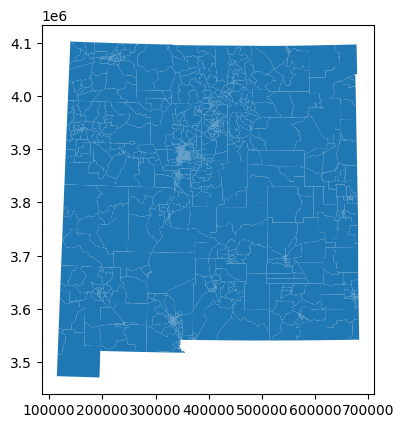

In [59]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()

In [60]:
len(election_df.columns)

76